For this notebook, you need to install : 
+ the **pyFAI library** : https://pyfai.readthedocs.io/en/stable/
+ **ImageD11** : https://imaged11.readthedocs.io/en/latest/

# 1 - Azimuthal integration

In [1]:
import fabio
import numpy as np
import matplotlib.pyplot as plt
import os
import pyFAI
import h5py
from utils import *

### Parameters of the experiment

In this first cell, you input all your experiment parameters. <br />
The **number of rotation** corresponds to the number of steps in omega (_i.e._ rotation of the sample).

In [2]:
experiment_number = 'ma6795'
experiment_date = '20250826'
detector = 'eiger'
number_of_rotations = 1800

path_RAW_DATA = f'/data/visitor/{experiment_number}/id11/{experiment_date}/RAW_DATA'

print('All the existing samples :')
for p in os.listdir(path_RAW_DATA):
    print(p)

All the existing samples :
CeO2_200
tdxrd_test_posth8
PCT_check_after_mdt
sample
live_h8_60sec
subvolume_highres_posth12
Fe_T0_tdxrd_no_furnace
textom_posth12
live_h10_90sec
SI_end
textom_posth10
test_tdxrd
test_tdxrd_post_h2
Fe_liveheating_TDXRD_redo
tdxrd_test_posth12_redo
live_h5_30sec
textom_post_h1_redo_2
CeO2_400
live_h13_240sec
textom_posth13
textom_post_h1_redo
live_h11_120sec
textom_post_h1
test_tdxrd_post_h4
CeO2
clear_hotpix_eiger
Fe_TDXRD_610_sample2_nofurnace_redo
tdxrd_post_h1_0.1_redo
CeO2_200mm
tdxrd_test_posth13
textom_post_h8_redo
textom_post_h9
live_h9_120sec
Textom_t0_redo
Fe_TDXRD_610_sample2_nofurnace
textom_posth14_post_beamdown
Fe_liveheating_TDXRD_redo_610
live_h1_60sec
test_texture
textom_posth14_redo
distortion
tdxrd_test_posth14
tdxrd_test_posth13_redo
subvolume_highres_redo
ma6795_id11.h5
test_macro
live_h7_60sec
tdxrd_test_posth11
textom_posth15
tdxrd_test_posth12_redo2
align_textom
textom_post_h5
Si_200
textom_posth10_redo
textom_posth11
align_2
tdxrd_tes

You select (*copy past below*) the sample you want to reconstruct among all the samples that were created during the experiment at ID11.

In [3]:
# Input the sample you want to work with
sample = 'textom_posth14_post_beamdown'

print('All the existing dataset for this sample :')
for p in os.listdir(os.path.join(path_RAW_DATA,sample)):
    print(p[len(sample)+1:])

All the existing dataset for this sample :
amdown.h5
align
z13_redo
z9_redo
z10_redo
z11_redo
z7_redo
z0_redo
z14_redo
z12_redo
z3_redo
z2_redo
z6_redo
z4_redo
z8_redo
z5_redo
z1_redo


You select (*copy past below*) any dataset you want that will be used to select the integration parameters for the rest of the study.

In [4]:
# Input the z-slice used for testing the workflow.
dataset = 'z0_redo'

Setting up different path for the chosen sample, and checking that the number of existing files corresponds to the number of dty steps of the experimental scan.

In [5]:
#path of the dataset folder
path_ds = os.path.join(path_RAW_DATA, sample, sample+'_'+dataset)
#path of the dataset h5 file
path_h5 = os.path.join(path_ds, sample+'_'+dataset+'.h5')

# -1 for the h5 file
n_files = len(os.listdir(path_ds))-1

print(f'There is {n_files} files in this dataset folder ({n_files} dty steps)')

There is 105 files in this dataset folder (105 dty steps)


## Load 1 frame

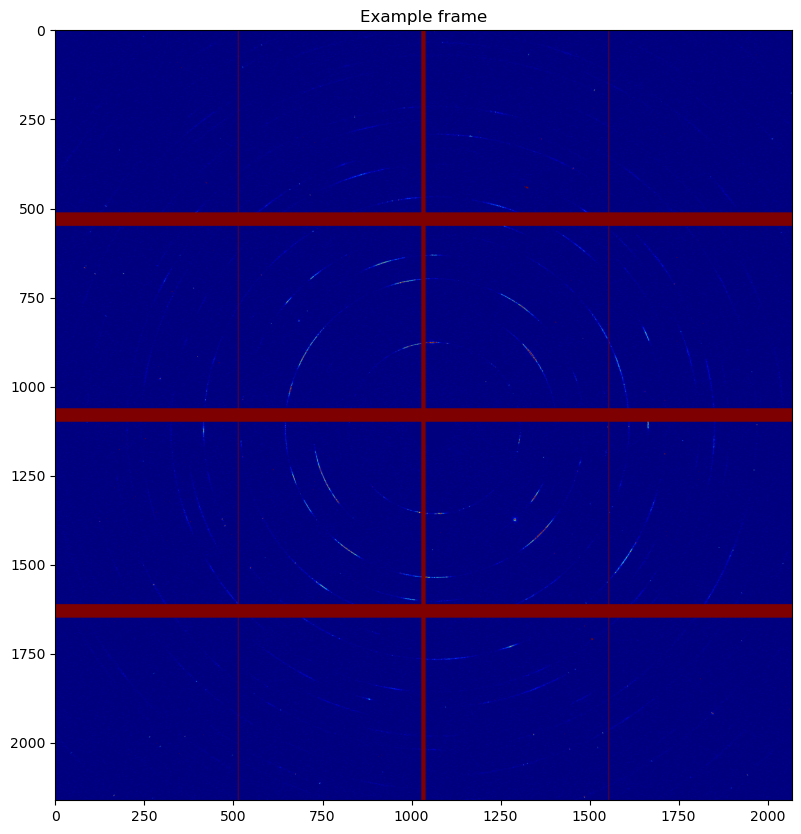

In [6]:
# Get interactive tools for plots
# %matplotlib widget

fig = plt.figure(figsize = (10, 10))
# Choose a single frame
## This is the image corresponding to the n_image omega step
n_image = 900
## This is the scan corresponding to the n_position dty step
n_position = int(n_files/2)+5

with h5py.File(path_h5, 'r') as file:
    im = file[f'{str(n_position)}.1/measurement/{detector}'][n_image,:,:]

plt.imshow(im,vmin =0,vmax=20, cmap = 'jet')

#plt.imshow(np.log10(im+1e-1),vmin =0,vmax=2, cmap = 'jet')
plt.title(f'Example frame')
plt.show()


## Chosing pyFAI integration parameters

The **poni file** corresponds to a calibration file done before (or after) the experiment to calibrate the detector distance from the sample and its tilts.<br />
The calibration is done with a silicon single crystal, hence the name : si_fit.<br />
The **mask file** is an image that maps all inactive pixels of the detector.<br />

+ **n_radial** : Number of radial bins (from the center to the edge of the detector)
+ **radial_range** : the integration will only be computed within these bounds.
+ **polarization_factor** : between -1 and +1. 0 for circular polarization.
+ **unit** : output units, "q_nm^-1" (default), "2th_deg", "r_mm".

In [7]:
n_radial = 2000
radial_range = (3,20)
polarization_factor = 0.95
unit = '2th_deg'

#Poni path, from the calibration step
poni_path = f'/data/visitor/{experiment_number}/id11/{experiment_date}/SCRIPTS/si_fit.poni'

#Mask path for the corresponding detector
mask_path = f'/data/visitor/{experiment_number}/id11/{experiment_date}/SCRIPTS/eiger_mask_E-08-0144_20250819.edf'

#Create a pyFAI integrator
ai = pyFAI.load(poni_path)
#load the mask
mask = fabio.open(mask_path).data

integration_args = {'npt':n_radial,'radial_range':radial_range,'unit':unit,'mask':mask,
                    'polarization_factor':polarization_factor}


We do the radial integration of the image we plotted before. <br />
You can get more detail about azimuthal integration on the pyFAI website : [Link towards pyfai.readthedocs](https://pyfai.readthedocs.io/en/stable/)

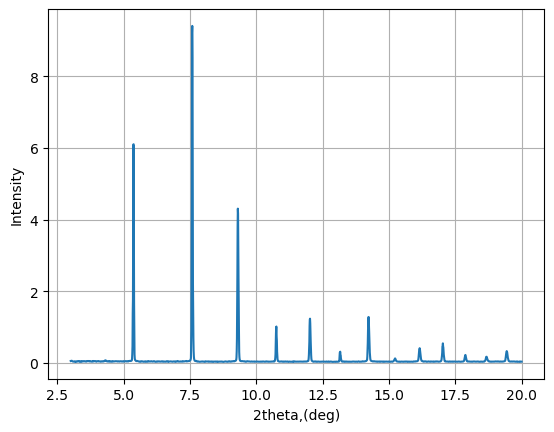

In [8]:
tt_deg, intens = ai.integrate1d_ng(im, **integration_args)

fig = plt.figure()
plt.plot(tt_deg, intens)
plt.xlabel('2theta,(deg)')
plt.ylabel('Intensity')
plt.grid()
# fig.show()

## Finding the peak positions

In [9]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())
# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( os.path.join( os.environ['HOME'],'Code', 'Tutorial', 'SCRIPTS'), 'ImageD11' )# ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )


# Setting path via: 
sys.path.insert(0, /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11 )
# Running from: /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11/ImageD11/__init__.py


In [10]:
import ImageD11.parameters
import ImageD11.unitcell
import ImageD11.transform

wavelength : depends on the Energy you used for this experiment : E = hc/lambda :: E ~= 12.3984/lambda

In [11]:
wavelength = 0.189723

This methods requires you to know which phase you are studying. <br />
Currently (06/10/2025), 3 crystal families are available within this workflow : cubic, orthorombic and hexagonal. <br />
In this case it is BCC cubic iron.

+ **a,b,c**: crystal lattice edges
+ **alpha, beta, gamma**: crystal lattice angles

In [12]:
a = 2.866
b = a
c = a
alpha = 90
beta = alpha
gamma = alpha
uc = ImageD11.unitcell.unitcell([a,b,c,alpha,beta,gamma],229)
uc.makerings( 2 )

+ **bragg_tt_deg_list**: list of angles corresponding to the bragg reflections (*i.e.* two thetas rings).
+ **n_tth**: Number of rings considered for the integration

In [13]:
bragg_tt_deg_list = np.degrees( 2*np.arcsin( wavelength*np.array(uc.ringds)/2 ) )
n_tth = 9

Generate the ring parameters for n_tth rings

In [14]:
#Get the different hkls
hkl_list = []

cpt = 0
for ring in uc.ringds[:n_tth]:
    #This gives all the hkl that can produce this ring, multiplicity due to symmetry
    hkls = uc.ringhkls[ring]
    hkl_list.append(hkls[-1])
    print('Ring n°{}, Multiplicity: {}, hkl: {}, dspace: {:.4f}'.format(cpt, len(hkls), hkls[-1], ring))
    cpt +=1

Ring n°0, Multiplicity: 12, hkl: (1, 1, 0), dspace: 0.4934
Ring n°1, Multiplicity: 6, hkl: (0, 2, 0), dspace: 0.6978
Ring n°2, Multiplicity: 24, hkl: (2, 1, 1), dspace: 0.8547
Ring n°3, Multiplicity: 12, hkl: (2, 2, 0), dspace: 0.9869
Ring n°4, Multiplicity: 24, hkl: (0, 1, 3), dspace: 1.1034
Ring n°5, Multiplicity: 8, hkl: (2, 2, 2), dspace: 1.2087
Ring n°6, Multiplicity: 48, hkl: (2, 1, 3), dspace: 1.3055
Ring n°7, Multiplicity: 6, hkl: (4, 0, 0), dspace: 1.3957
Ring n°8, Multiplicity: 36, hkl: (4, 1, 1), dspace: 1.4803


In this next plot, the integrated pattern peaks should match with the theoretical peaks you computed. <br />
If some peaks are not matched, maybe you have some minor phases in your sample.

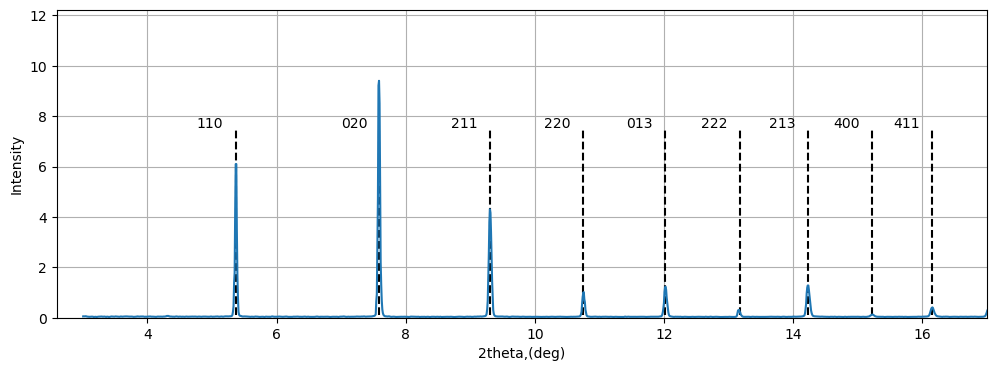

In [15]:
fig = plt.figure(figsize = (12,4))
ymax = np.max(intens)
cpt = 0
for hkl, bragg_twotheta_deg in zip(hkl_list, bragg_tt_deg_list):
    plt.plot([bragg_twotheta_deg]*2, [ymax*0.01, ymax*0.8], 'k--')
    plt.text(bragg_twotheta_deg-0.6, ymax*0.8, f'{hkl[0]}{hkl[1]}{hkl[2]}', color='k')
    cpt += 1
plt.plot(tt_deg, intens)

plt.xlabel('2theta,(deg)')
plt.ylabel('Intensity')
plt.xlim([2.6, 17])
plt.ylim(-0, ymax*1.3)
plt.grid()
# fig.show()

For texture tomography, we are only interested in the signal around peaks (the rest of the picture is just noise or minor phases). <br />
In the next step, we chose a small two theta window to select how much signal we extract around each peak. <br />
+ **fixed_width_deg**: two thetas window around one peak for the integration.
+ **tt_ranges**: list of two thetas ranges for integrations.

In [16]:
fixed_width_deg = 0.4
tt_ranges = [(tt_deg-fixed_width_deg/2, tt_deg+fixed_width_deg/2) for tt_deg in bragg_tt_deg_list[:n_tth]]


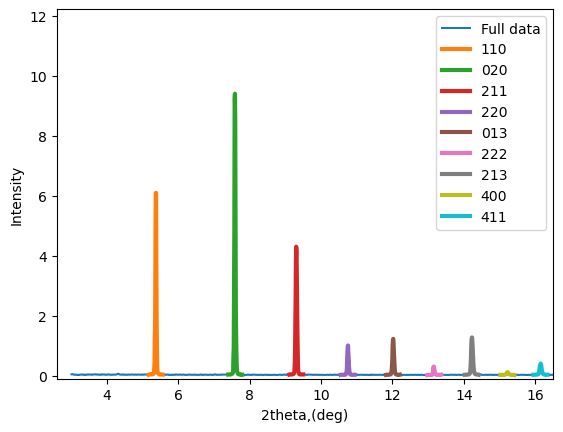

In [17]:
fig = plt.figure()
plt.plot(tt_deg, intens)
for tt_range in tt_ranges:
    peak_indicies = np.logical_and(tt_deg>=tt_range[0], tt_deg<tt_range[1])
    plt.plot(tt_deg[peak_indicies], intens[peak_indicies], linewidth=3)

peak_masks = [np.logical_and(tt_deg>=tt_range[0], tt_deg<tt_range[1]) for tt_range in tt_ranges] 
any_peak_mask = np.sum(np.stack(peak_masks, axis = -1), axis = -1) > 0

plt.xlabel('2theta,(deg)')
plt.ylabel('Intensity')
plt.xlim([2.6, 16.5])
plt.ylim(-ymax*0.01, ymax*1.3)
leg = [f'{hkl[0]}{hkl[1]}{hkl[2]}' for hkl in hkl_list]
leg.insert(0, 'Full data')
plt.legend(leg)
# fig.show()

## 2d azimuthal integration

Texture tomography is the middle ground between powder and single crystal diffraction, between nice diffraction rings and sharp spotty diffraction peaks.<br />
Thus, the signal not only depends on the two theta angle, but also on the azimuthal angle (in the detector plane).
+ **n_azim**: number of azimuthal bins (at a given radius), only for 2d integration.
+ **azi_range**: azimuthal range for the integration. For the Eiger detector on ID11, -180 is the left (west)
+ **integration_args2D**: arguments for 2D integration

In [18]:
n_azim = 1800
azi_range = [-180, 180]

integration_args2D = {'npt_rad':n_radial, 'npt_azim':n_azim, 'unit':'2th_deg','radial_range':radial_range,
                'mask':mask, 'polarization_factor':polarization_factor}

Text(0, 0.5, 'eta,(deg)$')

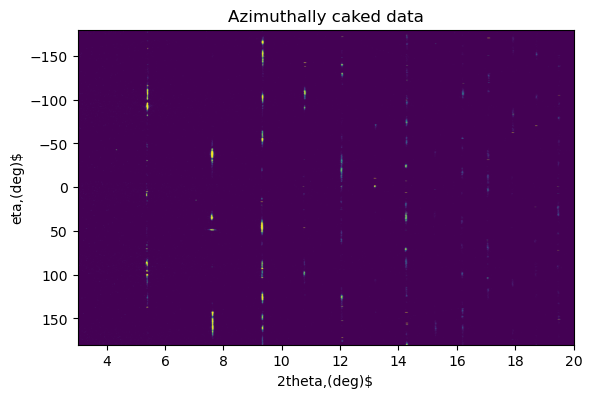

In [19]:
cake_data, tt_deg, azim_deg  = ai.integrate2d(im, **integration_args2D)
tt_stepsize = tt_deg[1] - tt_deg[0]
cake_imshow_extent = (tt_deg[0]-tt_stepsize/2, tt_deg[0-1]+tt_stepsize/2, 180, -180)

fig = plt.figure()
plt.imshow(cake_data,
           extent=cake_imshow_extent,
           vmin=ymax*0.05, vmax=ymax*0.9, aspect=0.03)

plt.title('Azimuthally caked data')
plt.xlabel('2theta,(deg)$')
plt.ylabel('eta,(deg)$')
# fig.show()

The imported mask is only valid for 2D "raw" images. The 2D integration process is not linear (some 2D integrated pixels correspond to a combination of different pixel from the raw image). <br />
In the next step, we create a mask for the 2D integrated pictures. Here, we create a 2D integrated mask (especially useful for eiger)

/tmp/ipykernel_165678/1021340000.py:5: RuntimeWarning: divide by zero encountered in divide
  n_pix = 1/variance**2


[Text(0, -200.0, ''),
 Text(0, -150.0, ''),
 Text(0, -100.0, ''),
 Text(0, -50.0, ''),
 Text(0, 0.0, ''),
 Text(0, 50.0, ''),
 Text(0, 100.0, ''),
 Text(0, 150.0, ''),
 Text(0, 200.0, '')]

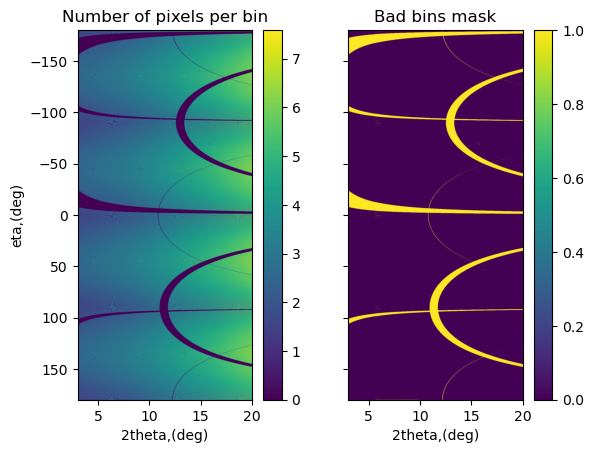

In [20]:
ones = np.ones(ai.get_shape())
integration_args_trick = {'npt_rad':n_radial, 'npt_azim':n_azim, 'unit':'2th_deg','radial_range':(3,20),
                          'mask':mask, 'polarization_factor':None, 'correctSolidAngle':False}
_, _, _, variance = ai.integrate2d(ones, variance=ones, **integration_args_trick)
n_pix = 1/variance**2
n_pix[variance == 0] = 0

fig = plt.figure()

ax = plt.subplot(1,2,1)
plt.imshow(n_pix,
           extent=cake_imshow_extent,
           aspect=0.1)

plt.title('Number of pixels per bin')
plt.xlabel('2theta,(deg)')
plt.ylabel('eta,(deg)')
plt.colorbar()

n_pix[n_pix == 0]= np.nan
bins_mask = n_pix < 0.4 * np.nanmedian(n_pix, axis = 0)[np.newaxis, :]
bins_mask += np.isnan(n_pix)

ax = plt.subplot(1,2,2)
plt.imshow(bins_mask,
           extent=cake_imshow_extent,
           aspect=0.1)

plt.title('Bad bins mask')
plt.xlabel('2theta,(deg)')
plt.colorbar()
ax.set_yticklabels([])
# fig.show()

## Background substraction

### method 0

No background subtraction at all. This is valid for photon counting detectors.

In [21]:
bg = np.zeros(n_radial)

### method 1

In [22]:
# mean_data_radial = np.sum(~bins_mask*cake_data, axis = 0) / np.sum(~bins_mask, axis = 0)
# peak_masks = [np.logical_and(tt_deg>=tt_range[0], tt_deg<tt_range[1]) for tt_range in tt_ranges] 
# any_peak_mask = np.sum(np.stack(peak_masks, axis = -1), axis = -1) > 0

# # Filter the peaks from the data
# mean_data_nopeaks = mean_data_radial[~any_peak_mask]
# tt_nopeaks = tt_deg[~any_peak_mask]

# #Possibility to play on the bracket upper limit to fit more data or not
# bg_fit_coeffs = np.polyfit(tt_nopeaks[100:1000], mean_data_nopeaks[100:1000], 0) 
# bg = np.polyval(bg_fit_coeffs, tt_deg)
# bg = bg*0

# fig = plt.figure()
# ax = plt.subplot(2,1,1)
# plt.plot(tt_deg, mean_data_radial)
# plt.plot(tt_deg, bg)
# plt.legend(['Data', 'Background'])
# plt.xlim(3, 16.5)
# plt.ylim(-ymax*0.01, ymax*0.2)
# plt.grid()

# ax = plt.subplot(2,1,2)
# plt.plot(tt_deg, (mean_data_radial- bg), color = 'C2')
# plt.ylabel('Data - Background')
# plt.xlim(3, 16.5)
# plt.ylim(-ymax*0.01, ymax*0.2)
# plt.xlabel(r'$2\theta\,\text{(deg)}$')
# plt.grid()
# fig.show()

In [23]:
# # peak mask masks one column in the cake file where there is the 2 thetas corresponding to 1 hkl
# cumul = 0
# for ii, hkl in enumerate(peak_masks):
#     plt.plot(hkl+ 1.2*cumul)
#     cumul +=1

### method 2 (with background) / not for eiger

In [24]:
# bkg_path = f'/data/visitor/{experiment_number}/id11/{experiment_date}/PROCESSED_DATA/Si_cube/bkg.edf'
# bkg = fabio.open(bkg_path).data

In [25]:
# q, bk_int = ai.integrate1d(bkg,**integration_args)


In [26]:
# fig = plt.figure()
# ax = plt.subplot(2,1,1)
# plt.plot(tt_deg, mean_data_radial)
# plt.plot(tt_deg,bk_int)
# plt.legend(['Data', 'Background'])
# plt.xlim(3, 16.5)
# plt.ylim(108, 133)
# plt.grid()

# ax = plt.subplot(2,1,2)
# plt.plot(tt_deg, (mean_data_radial- bk_int), color = 'C2')
# plt.ylabel('Data - Background')
# plt.xlim(3, 16.5)
# plt.ylim(-3, 22)
# plt.xlabel(r'$2\theta\,\text{(deg)}$')
# plt.grid()
# fig.show()

## Azimuthal mask

In a previous step, we selected data only around particular two theta angles.<br />
Here, we plot the 2D integrated mask at these particular two theta values (*i.e.* places where peaks touch the gaps).

In [27]:
bins_mask.shape, len(peak_masks[0])

((1800, 2000), 2000)

(-0.5, 11.0)

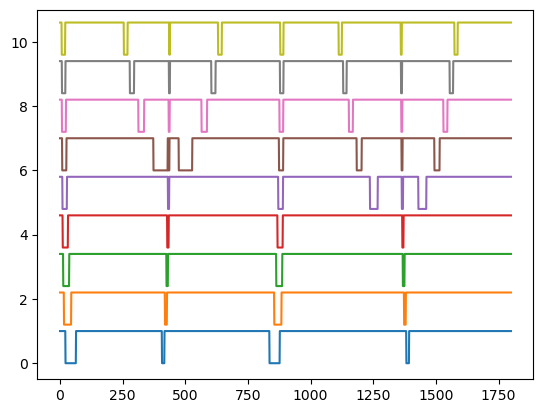

In [28]:
cumul = 0

figure = plt.figure()
azimuthal_masks = []
for ii, hkl in enumerate(bragg_tt_deg_list[:n_tth]):
    azimuthal_masks.append( np.any(~bins_mask[:, peak_masks[ii]], axis = 1))
    plt.plot(azimuthal_masks[-1]+ 1.2*cumul)
    cumul +=1
plt.ylim(-0.5, n_tth+2)
#On this graph, all lines on integers mean that the mask is equal to 1, otherwise 0

## Process 1 full frame

Now that all parameters have been tuned on 1 image, we create a function to automatically process one frame.

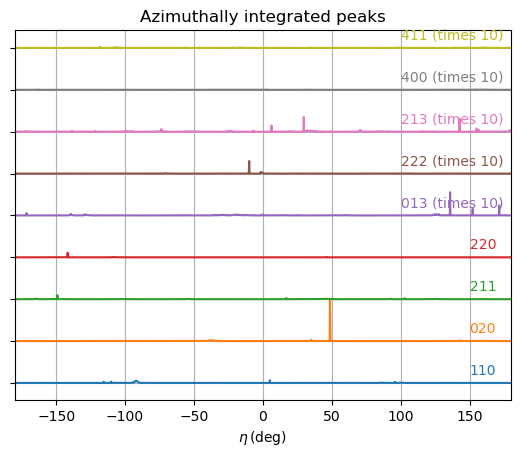

In [29]:
def process_one_frame(image_data):

    cake_data, _, _  = ai.integrate2d(image_data, **integration_args2D)
    cake_data = cake_data - bg[np.newaxis, :]
    output_data = []
    for peak_mask in peak_masks:
        this_peak_data = np.sum(cake_data[:, peak_mask], axis = -1)
        output_data.append(this_peak_data)

    return np.stack(output_data, axis = -1)
    
integrated_data = process_one_frame(im)

plot_scale = np.max(integrated_data)

fig = plt.figure()
for hkl_index, hkl in enumerate(hkl_list):

    if hkl_index <= 3:
        plt.plot(azim_deg, integrated_data[:, hkl_index] + hkl_index * plot_scale)
        plt.text(150, hkl_index * plot_scale + plot_scale/5, f'{hkl[0]}{hkl[1]}{hkl[2]}', color = f'C{hkl_index}')
    elif hkl_index > 3:
        plt.plot(azim_deg, integrated_data[:, hkl_index]*10 + hkl_index * plot_scale)
        plt.text(100, hkl_index * plot_scale + plot_scale/5, f'{hkl[0]}{hkl[1]}{hkl[2]} (times 10)', color = f'C{hkl_index}')

plt.title('Azimuthally integrated peaks')
plt.yticks( np.arange(len(hkl_list))*plot_scale, labels = [])
plt.grid()
plt.xlim(-180, 180)
# plt.ylim(-1e4, 2.3e5)
plt.xlabel(r'$\eta\,\text{(deg)}$')
plt.show()

Saving all the integration parameters for later, and the future you will be happy to found these somewhere.

In [30]:
integration_metadata = {'npt_azim': n_azim,
                  'npt_rad': n_radial,
                  'radial_range':radial_range,
                  'poni_path': poni_path,
                  'mask_path': mask_path,
                  'polarization_factor': polarization_factor,
                  'unit': unit,
                 }

data = {'wavelength':wavelength,
        'bragg_tt_deg_list':bragg_tt_deg_list[:n_tth],
        'hkl_list':hkl_list,
        'tt_ranges':tt_ranges,
        'peak_masks':peak_masks,
        'azimuthal_masks':azimuthal_masks,
        'bg':bg,
         }


Check that every lists is the same length. Otherwise there is a problem

In [31]:
for k in data.keys():
    if 'wave' not in k:
        print(f'{k}: {len(data[k])}')

bragg_tt_deg_list: 9
hkl_list: 9
tt_ranges: 9
peak_masks: 9
azimuthal_masks: 9
bg: 2000


## Save integration / mask parameters

In [32]:
import pickle
with open('auxillary_files/phase_data.npy', 'wb') as fid:
    pickle.dump(data, fid)

with open('auxillary_files/integration_metadata.npy', 'wb') as fid:
    pickle.dump(integration_metadata, fid)

Do this integration for every picture of every sample you have. <br />
Here we set up a folder were thes integrated intensities will be saved.

In [33]:
output_folder = f'/data/visitor/{experiment_number}/id11/{experiment_date}/PROCESSED_DATA/integrated_intensities/{sample}/{sample}_{dataset}'
os.path.split(output_folder)


('/data/visitor/ma6795/id11/20250826/PROCESSED_DATA/integrated_intensities/textom_posth14_post_beamdown',
 'textom_posth14_post_beamdown_z0_redo')

PS : if you run this script for the first time and get a "file not found error", you may have to manually create a integrated intensities within the PROCESSED_DATA folder.

In [34]:
if not os.path.exists(os.path.split(output_folder)[0]):
    os.mkdir(os.path.split(output_folder)[0])
    os.mkdir(output_folder)
elif not os.path.exists(output_folder):
    os.mkdir(output_folder)

## Launch batch script to process multiple images

Double checking where we will save everything 

In [35]:
print('Dataset : {}, output folder : {}'.format(dataset, output_folder))

Dataset : z0_redo, output folder : /data/visitor/ma6795/id11/20250826/PROCESSED_DATA/integrated_intensities/textom_posth14_post_beamdown/textom_posth14_post_beamdown_z0_redo


In the next cell, we send all jobs to the cluster to perform the cake integration and save the integrated intensities in the output folder. <br />
It represents a lot of slurm jobs, make sure everything is ready before executing this cell.

In [36]:
import time

# Make folder for slurm.out files
slurm_logfiles_folder = 'slurm_logfiles'
#Create a folder where the integrated intensities will be saved
if not os.path.exists(slurm_logfiles_folder):
    os.mkdir(slurm_logfiles_folder)

for slize_index in range(0,3):
    #dataset = f'z{slize_index}'
    dataset = f'z{slize_index}_redo'
    name_output = dataset
    output_folder = f'/data/visitor/{experiment_number}/id11/{experiment_date}/PROCESSED_DATA/integrated_intensities/{sample}/{sample}_{dataset}'
    os.path.split(output_folder)
    #Create a folder where the integrated intensities will be saved
    if not os.path.exists(os.path.split(output_folder)[0]):
        os.mkdir(os.path.split(output_folder)[0])
        os.mkdir(output_folder)
    elif not os.path.exists(output_folder):
        os.mkdir(output_folder)
        
    # Set up the functions and create a dat in processed folder
    write_init(sample = sample, dataset = dataset, experiment = experiment_number, 
               date = experiment_date, detector = detector, 
               number_of_rotations = number_of_rotations, outfile = name_output)
    
    for position_index in range(n_files): 
        os.system(f"sbatch batch_scripts/{name_output}.slurm {position_index}")

Current working directory : /gpfs/easy/data/id11/inhouse1/Texture_workflow/texture_tutorial/SCRIPTS
Submitted batch job 27297282
Submitted batch job 27297283
Submitted batch job 27297284
Submitted batch job 27297285
Submitted batch job 27297286
Submitted batch job 27297287
Submitted batch job 27297288
Submitted batch job 27297289
Submitted batch job 27297290
Submitted batch job 27297291
Submitted batch job 27297292
Submitted batch job 27297293
Submitted batch job 27297294
Submitted batch job 27297295
Submitted batch job 27297296
Submitted batch job 27297297
Submitted batch job 27297298
Submitted batch job 27297299
Submitted batch job 27297300
Submitted batch job 27297301
Submitted batch job 27297302
Submitted batch job 27297303
Submitted batch job 27297304
Submitted batch job 27297305
Submitted batch job 27297306
Submitted batch job 27297307
Submitted batch job 27297308
Submitted batch job 27297309
Submitted batch job 27297310
Submitted batch job 27297311
Submitted batch job 27297312
S